In [ ]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, mean_squared_error

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
import os

##############for github
#task = "regression"
#train_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_train.pt")
#val_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_val.pt")
#test_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_test.pt")
##############

task = "regression"
train_path = f"/content/drive/MyDrive/GNN_model_TRPM8_Drug_Potency_prediction/4_train_test_split/random_split/{task}/{task}_train.pt"
val_path   = f"/content/drive/MyDrive/GNN_model_TRPM8_Drug_Potency_prediction/4_train_test_split/random_split/{task}/{task}_val.pt"
test_path  = f"/content/drive/MyDrive/GNN_model_TRPM8_Drug_Potency_prediction/4_train_test_split/random_split/{task}/{task}_test.pt"

print("Train file exists:", os.path.exists(train_path))
print("Val file exists:", os.path.exists(val_path))
print("Test file exists:", os.path.exists(test_path))

#load files with weights_only set to False
train_data = torch.load(train_path, weights_only=False)
val_data   = torch.load(val_path, weights_only=False)
test_data  = torch.load(test_path, weights_only=False)

print("Datasets loaded successfully.")

Train file exists: True
Val file exists: True
Test file exists: True
Datasets loaded successfully.


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # Three GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # Two linear layers for regression (graph-level readout)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        # Global pooling: aggregate node features to a graph-level embedding
        x = global_mean_pool(x, batch)
        # Apply the linear layers as a regressor
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

# -------------------------------
#  Loss, Model, and Optimizer Setup
# -------------------------------
# For regression, our model's output channel is 1 and we use MSELoss
model = GCN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -------------------------------
#  Training Loop
# -------------------------------
def train():
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        # For regression, targets are used directly
        loss = criterion(out.squeeze(), batch.y)
        loss.backward()
        optimizer.step()

# -------------------------------
# Evaluation Function
# -------------------------------
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.squeeze().cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return mean_squared_error(labels, preds)

# -------------------------------
# Run Training for 200 Epochs
# -------------------------------
for epoch in range(1, 101):
    train()
    val_metric = evaluate(val_loader)
    print(f"Epoch {epoch:03d} - MSE: {val_metric:.4f}")

# -------------------------------
# Final Test Evaluation
# -------------------------------
test_metric = evaluate(test_loader)
print(f"\nTest MSE: {test_metric:.4f}")

Epoch 001 - MSE: 26.4517
Epoch 002 - MSE: 1.3098
Epoch 003 - MSE: 1.7961
Epoch 004 - MSE: 1.1068
Epoch 005 - MSE: 1.2503
Epoch 006 - MSE: 1.1435
Epoch 007 - MSE: 1.1295
Epoch 008 - MSE: 1.3404
Epoch 009 - MSE: 1.0770
Epoch 010 - MSE: 1.0590
Epoch 011 - MSE: 1.2139
Epoch 012 - MSE: 1.1784
Epoch 013 - MSE: 1.0905
Epoch 014 - MSE: 1.2052
Epoch 015 - MSE: 1.0224
Epoch 016 - MSE: 1.2793
Epoch 017 - MSE: 1.0116
Epoch 018 - MSE: 1.2601
Epoch 019 - MSE: 1.2248
Epoch 020 - MSE: 1.0540
Epoch 021 - MSE: 1.3698
Epoch 022 - MSE: 1.1634
Epoch 023 - MSE: 1.0792
Epoch 024 - MSE: 1.0798
Epoch 025 - MSE: 1.0940
Epoch 026 - MSE: 1.3964
Epoch 027 - MSE: 1.0773
Epoch 028 - MSE: 1.0012
Epoch 029 - MSE: 1.5103
Epoch 030 - MSE: 1.2056
Epoch 031 - MSE: 1.0913
Epoch 032 - MSE: 1.5745
Epoch 033 - MSE: 1.1977
Epoch 034 - MSE: 1.0610
Epoch 035 - MSE: 1.2037
Epoch 036 - MSE: 1.1609
Epoch 037 - MSE: 1.1636
Epoch 038 - MSE: 1.1124
Epoch 039 - MSE: 1.1581
Epoch 040 - MSE: 1.2193
Epoch 041 - MSE: 1.0101
Epoch 042 - MSE

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # Five GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        # Two linear layers for regression on the graph-level embedding
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Pass through the 5 GCN layers with ReLU activations
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))

        # Global mean pooling to obtain a graph-level representation
        x = global_mean_pool(x, batch)

        # Fully connected layers for regression
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.3, training=self.training)  # Dropout rate set to 0.3
        x = self.lin2(x)
        return x

#  Loss, Model, and Optimizer Setup
model = GCN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Learning rate set to 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop
def train():
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        # For regression, use the raw target values
        loss = criterion(out.squeeze(), batch.y)
        loss.backward()
        optimizer.step()

# Evaluation Function
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.squeeze().cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return mean_squared_error(labels, preds)

# Run Training for 100 Epochs
for epoch in range(1, 101):
    train()
    val_mse = evaluate(val_loader)
    print(f"Epoch {epoch:03d} - MSE: {val_mse:.4f}")

# Final Test Evaluation
test_mse = evaluate(test_loader)
print(f"\nTest MSE: {test_mse:.4f}")

Epoch 001 - MSE: 47.4917
Epoch 002 - MSE: 37.3044
Epoch 003 - MSE: 10.9361
Epoch 004 - MSE: 2.6307
Epoch 005 - MSE: 1.6828
Epoch 006 - MSE: 0.9838
Epoch 007 - MSE: 1.0428
Epoch 008 - MSE: 1.0782
Epoch 009 - MSE: 1.0251
Epoch 010 - MSE: 0.9895
Epoch 011 - MSE: 1.1450
Epoch 012 - MSE: 1.0444
Epoch 013 - MSE: 1.0395
Epoch 014 - MSE: 1.0253
Epoch 015 - MSE: 1.0111
Epoch 016 - MSE: 1.0520
Epoch 017 - MSE: 1.0533
Epoch 018 - MSE: 1.0188
Epoch 019 - MSE: 1.0567
Epoch 020 - MSE: 0.9690
Epoch 021 - MSE: 1.0005
Epoch 022 - MSE: 0.9678
Epoch 023 - MSE: 0.9952
Epoch 024 - MSE: 1.0071
Epoch 025 - MSE: 1.1328
Epoch 026 - MSE: 0.9723
Epoch 027 - MSE: 1.0074
Epoch 028 - MSE: 0.9770
Epoch 029 - MSE: 1.0059
Epoch 030 - MSE: 0.9826
Epoch 031 - MSE: 0.9686
Epoch 032 - MSE: 1.1417
Epoch 033 - MSE: 1.0458
Epoch 034 - MSE: 0.9730
Epoch 035 - MSE: 1.0255
Epoch 036 - MSE: 0.9689
Epoch 037 - MSE: 1.0005
Epoch 038 - MSE: 1.0713
Epoch 039 - MSE: 1.0268
Epoch 040 - MSE: 1.0107
Epoch 041 - MSE: 1.4092
Epoch 042 - M

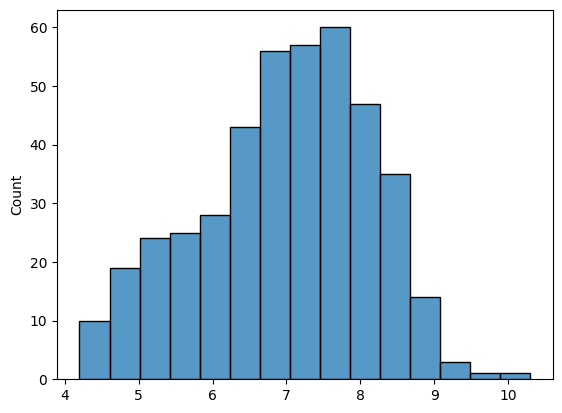

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot([data.y.item() for data in train_data])
plt.show()
